In [9]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
import numpy as np
import utils
from ImageMatcher import ImageMatcher, ImagePair
import h5py
from scipy.spatial.transform import Rotation as Rot
import cv2
import matplotlib.pyplot as plt
from pathlib import Path
import subprocess
from glob import glob
import os
import sys
import copy
from timer import Timer

In [15]:
def compute_and_export_image_pairs(img_pairs_path, frames,
                                   matcher, kf_interval, override):
    image_pairs = []
    closures = []
    still_cnt = 0

    if not override and os.path.isfile(img_pairs_path):
        print('Loading existing file', img_pairs_path)
        image_pairs = utils.import_image_pairs(img_pairs_path, frames)
        for p in image_pairs:
            if p.still:
                still_cnt += 1
            if p.i != p.j - 1:
                closures.append(p)
    else:

        with Timer(msg_prefix='Adj frame time: '):
            for i in range(0, len(frames) - 1):
                p = matcher.match(
                    i, i+1,
                    min_match_count=60,
                    ransac_max_iters=2000,
                    #keep_percent=0.7,
                    verbose=True,
                )
                if p is None:
                    print('No match found for frames', i, i+1)
                image_pairs.append(p)

        for i in range(0, len(frames) - kf_interval, kf_interval):
            for j in range(i + kf_interval, len(frames), kf_interval):
                if matcher.sift_kds[i] is None or matcher.sift_kds[j] is None:
                    continue
                p = matcher.match(i, j, 'sift',
                                min_match_count=25)
                if p is None:
                    continue
                closures.append(p)
                image_pairs.append(p)

    print('Number of loop closures:', len(closures))
    print('Total number of image pairs:', len(image_pairs))
    print('Number of still pairs:', still_cnt)

    if override or (not os.path.isfile(img_pairs_path)):
        utils.export_image_pairs(img_pairs_path, image_pairs)

    return image_pairs, closures

def compute_errors(in_vid_path, video_width):

    cpe, cpg = utils.load_est_gt_poses(
        in_vid_path, video_width)

    cam_params_est, cam_params_gt = utils.set_ref_cam(0, cpe, cpg)

    # Compute the angular pose error and hfov error between cam_params and cam_params_gt
    angular_err_abs = []
    angular_err_rel = []
    hfov_err_abs = []
    hfov_err_rel = []
    cam_indices = []

    for i in sorted(cam_params_est.keys()):
        R = cam_params_est[i]['R']
        R_gt = cam_params_gt[i]['R']

        ae = np.degrees(Rot.from_matrix(R @ R_gt.T).magnitude())
        angular_err_abs.append(ae)
        angular_err_rel.append(ae / max(np.degrees(Rot.from_matrix(R_gt.T).magnitude()), 0.1))

        hfove = np.abs(cam_params_est[i]['hfov'] - cam_params_gt[i]['hfov'])
        hfov_err_abs.append(hfove)
        hfov_err_rel.append(hfove / cam_params_gt[i]['hfov'])
        cam_indices.append(i)
    angular_err_abs = np.array(angular_err_abs) * 1.5
    print(f'angular error mean: {np.mean(angular_err_abs):.5f}, '
        f'max: {np.max(angular_err_abs):.5f}')
    print(f'hfov error mean: {np.mean(hfov_err_abs):.5f}, max: {np.max(hfov_err_abs):.5f}')

    fig, ax = plt.subplots(dpi=150, figsize=(5, 4))
    ax.set_title('Absolute Error')
    ax.plot(angular_err_abs, label='angular pose')
    ax.plot(hfov_err_abs, label='fov')
    ax.set_xlabel('Frame')
    ax.set_ylabel('Degrees')
    #ax.set_ylim(-0.3, 6.2)
    #ax.grid()
    #ax.set_yticks(np.arange(0, 8.5, 2))
    ax.legend()
    plt.show()

    return angular_err_abs, hfov_err_abs, cam_params_est

def graph_AV(image_pairs, frames, cam_params_est):
    idx2pair = {}
    for p in image_pairs:
        idx2pair[(p.i, p.j)] = p

    av = []
    for i in range(0, len(frames) - 1):
        p = idx2pair[(i, i+1)]
        av.append(utils.avg_quad_angular_velocity(p, cam_params_est[i]))

    # Moving average filter to smooth out the angular velocity
    # preserve the length of the array (padding = same as edge)
    av.insert(0, av[0])
    av.append(av[-1])
    av = np.convolve(av, np.ones(3) / 3, mode='valid')

    still_thresh = 0.2
    fig, ax = plt.subplots(dpi=150, figsize=(5, 4))
    ax.set_title('Apparent Angular Velocity')
    # plot av with thin line width.
    ax.plot(av, color='black', linewidth=0.5)
    ax.scatter(np.arange(0, len(av)), av, c=['red' if a < still_thresh
                                            else 'blue' for a in av], s=5)
    #ax.set_xlim(390, 660)
    #ax.set_ylim(-0.05, 0.65)
    ax.grid()
    ax.set_xlabel('Frame')
    ax.set_ylabel('Degrees per frame')
    fig.tight_layout()
    plt.show()

    return idx2pair, av

def export_AV(idx2pair, av, still_thresh, image_pairs, img_pairs_path):
    cnt = 0
    for i in range(0, len(av)):
        p = idx2pair[(i, i+1)]
        p.still = av[i] < still_thresh
        if p.still:
            cnt += 1
    print(f'Number of still pairs: {cnt}')
    utils.export_image_pairs(img_pairs_path, image_pairs)

Using video: t000-v00
Loading existing file /Users/richard/Desktop/Motorized-Dataset/t000-v00-pairs.h5
Number of loop closures: 36
Total number of image pairs: 935
Number of still pairs: 0
Optimizing poses for t000-v00.
Loaded 935 image pairs.
iter      cost      cost_change  |gradient|   |step|    tr_ratio  tr_radius  ls_iter  iter_time  total_time
   0  1.584772e+06    0.00e+00    3.40e+05   0.00e+00   0.00e+00  1.00e+04        0    2.43e-01    4.80e-01
   1  1.161472e+06    4.23e+05    1.63e+05   0.00e+00   1.17e+00  3.00e+04        1    6.44e-01    1.12e+00
   2  6.600443e+05    5.01e+05    1.60e+05   4.00e+03   1.47e+00  9.00e+04        1    3.73e-01    1.50e+00
   3  2.898949e+05    3.70e+05    3.94e+05   8.26e+03   1.49e+00  2.70e+05        1    3.90e-01    1.89e+00
   4  1.743331e+05    1.16e+05    3.61e+05   6.10e+03   1.37e+00  8.10e+05        1    3.81e-01    2.27e+00
   5  1.449685e+05    2.94e+04    1.67e+05   3.93e+03   1.12e+00  2.43e+06        1    4.17e-01    2.69e+00


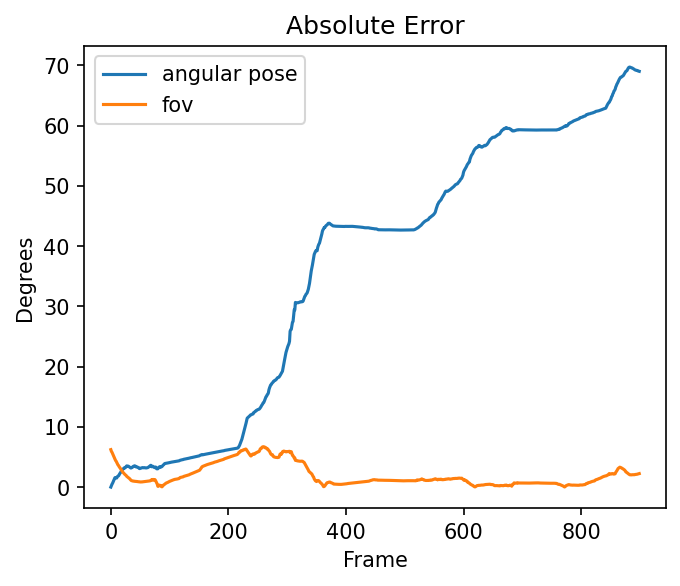

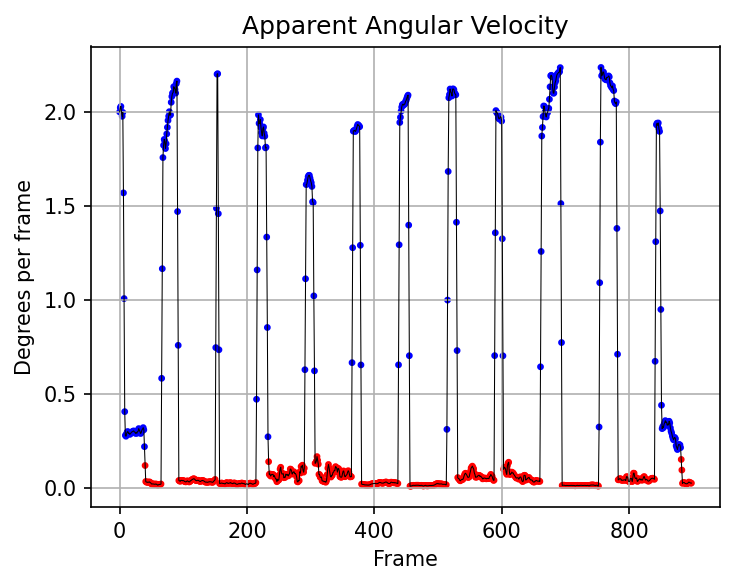

Number of still pairs: 622


In [16]:
DATA_DIR = '/Users/richard/Desktop/Motorized-Dataset/'
TRAJ_DIR = DATA_DIR

in_vid_paths = sorted(glob(DATA_DIR + '*.mp4'))

for in_vid_path in in_vid_paths[:1]:

    in_vid_stem = Path(in_vid_path).stem

    frames = utils.load_video(in_vid_path,
                            grayscale=True)
    masks = np.load(DATA_DIR + in_vid_stem + '-masks.npz')['masks']
    video_width = frames[0].shape[1]

    kf_interval = 30

    print('Using video:', in_vid_stem)

    override = False

    if override:
        matcher = ImageMatcher(frames, human_masks=masks, keyframe_interval=kf_interval)
    else:
        matcher = None

    img_pairs_path = DATA_DIR + in_vid_stem + '-pairs.h5'
    img_pairs, closures = compute_and_export_image_pairs(
        img_pairs_path, frames, matcher,
        kf_interval, override=override)

    opt_cmd = [
        '../Ceres/build/estimate', DATA_DIR, in_vid_stem + '-pairs.h5',
        'no',  # enable loop closures
        'no',  # load existing camera params
        'no',   # use_stills
    ]
    ret = subprocess.run(opt_cmd)
    if ret.returncode != 0:
        print(f'Ceres exited with non-zero return code!')

    angular_err_abs, hfov_err_abs, cam_params_est = compute_errors(
        in_vid_path, video_width)

    idx2pair, av = graph_AV(img_pairs, frames, cam_params_est)

    still_thresh = float(input('Enter still threshold: '))

    export_AV(idx2pair, av, still_thresh, img_pairs, img_pairs_path)


In [ ]:
aea_w_motion_comp = copy.deepcopy(angular_err_abs)
hea_w_motion_comp = copy.deepcopy(hfov_err_abs)

In [ ]:
print(f'angular error mean: {np.mean(aea_w_motion_comp):.5f}, '
      f'max: {np.max(aea_w_motion_comp):.5f}')
print(f'hfov error mean: {np.mean(hea_w_motion_comp):.5f}, max: {np.max(hea_w_motion_comp):.5f}')

In [ ]:
fig, ax = plt.subplots(dpi=150, figsize=(6, 5))
ax.set_title('Absolute Pose Error')
ax.plot(angular_err_abs, label='No motion thresh.', color='red')
ax.plot(aea_w_motion_comp, label='Has motion thresh.', color='green')
ax.set_xlabel('Frame')
ax.set_ylabel('Degrees')
ax.set_ylim(-0.5, 16.5)
#ax.set_yticks(np.arange(0, 8.5, 2))
#ax.grid()
ax.legend()
fig.tight_layout()
plt.show()

In [ ]:
fig, ax = plt.subplots(dpi=150, figsize=(6, 5))
ax.set_title('Absolute FoV Error')
ax.plot(hfov_err_abs, label='No motion thresh.', color='red')
ax.plot(hea_w_motion_comp, label='Has motion thresh.', color='green')
ax.set_xlabel('Frame')
ax.set_ylabel('Degrees')
ax.set_ylim(-0.5, 8.5)
#ax.set_yticks(np.arange(0, 8.5, 2))
ax.legend()
fig.tight_layout()
plt.show()

In [ ]:
np.argmax(angular_err_abs), np.argmax(hfov_err_abs)

In [ ]:
avb = []
for i in range(0, len(frames) - 1):
    p = idx2pair[(i, i+1)]
    avb.append(utils.better_apparent_vel(p, cam_params_est[i]))

# Moving average filter to smooth out the angular velocity
# preserve the length of the array (padding = same as edge)
avb.insert(0, av[0])
avb.append(av[-1])
avb = np.convolve(avb, np.ones(3) / 3, mode='valid')

still_thresh = 0.2
fig, ax = plt.subplots(dpi=150, figsize=(5, 4))
ax.set_title('Apparent Angular Velocity')
#ax.plot(avb, color='gray', linewidth=0.5)
ax.scatter(np.arange(0, len(avb)), avb, c=['red' if a < still_thresh
                                          else 'blue' for a in av], s=5)

ax.set_xlim(390, 660)
ax.set_ylim(-0.05, 0.65)
ax.grid()
ax.set_xlabel('Frame')
ax.set_ylabel('Degrees per frame')
fig.tight_layout()
plt.show()

In [ ]:
plt.plot(avb)
plt.xlim(595, 630)

In [ ]:
print(np.mean(av[465:485]),
      np.mean(avb[465:485]),
)

print(np.mean(av[595:630]),
      np.mean(avb[595:630]),
)

In [ ]:
mmin = np.inf
ffidx = 0
for p in image_pairs:
    if p.i == p.j - 1:
        if len(p.src_pts) < mmin:
            mmin = len(p.src_pts)
            ffidx = p.i
print(mmin, ffidx)

In [ ]:
utils.visualize_matches(image_pairs[ffidx], dpi=150)